## Quantum Optimal control to optimize the linear schedule

### Optimization of the quadratic driving

#### Imports

In [2]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
from src.qml_utils.utils import Schedule,SchedulerModel
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type
from scipy.optimize import minimize
from tqdm import trange

#### HyperParameters of the Optimal control

In [ ]:
tf=5
nsteps=50
number_of_parameters=10


#### Initialize the system

In [26]:
file_name:str='data/cki'
qq_filename:str='data/qq.p'


j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{8}$Be'


# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)
QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
QQoperator.get_hamiltonian()


# check the eigenstates
nlevels=5
egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]

print('deformation=',psi0.transpose().conjugate().dot(QQoperator.hamiltonian.dot(psi0)),'\n')

min_b=np.zeros(size_a+size_b)
min_b[0]=1
min_b[3]=1

min_b[0+size_a]=1

min_b[3+size_a]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=3


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.82it/s]
1424it [00:01, 739.32it/s]


size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.96it/s]
1256it [00:01, 769.18it/s]


Hamiltonian shape= (51, 51)
-30.295394613605517
deformation= [[-7.11447171]] 

initial state= [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
idx= 5
min energy= -15.405709999999996


#### Span the free parameter space

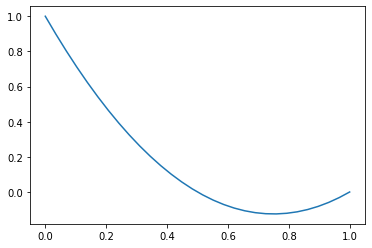

In [27]:
nsteps_b=50

bs=np.linspace(-2,2,nsteps_b)
energy_vs_b=np.zeros(nsteps_b)

time=np.linspace(0,tf,nsteps)
for j,b in enumerate(bs):
    psi=psi_configuration
    dt=time[1]-time[0]
    
    h=1-(1+b)*(time/tf)+b*(time/tf)**2
    
    for i,t in enumerate(time):
        time_hamiltonian=h[i]*InitialHamiltonian.hamiltonian+(1-h[i])*TargetHamiltonian.hamiltonian
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    energy_vs_b[j]=np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs)
    psi=psi


plt.plot(time,h)
plt.show()

#### Results

0.07504074111996492


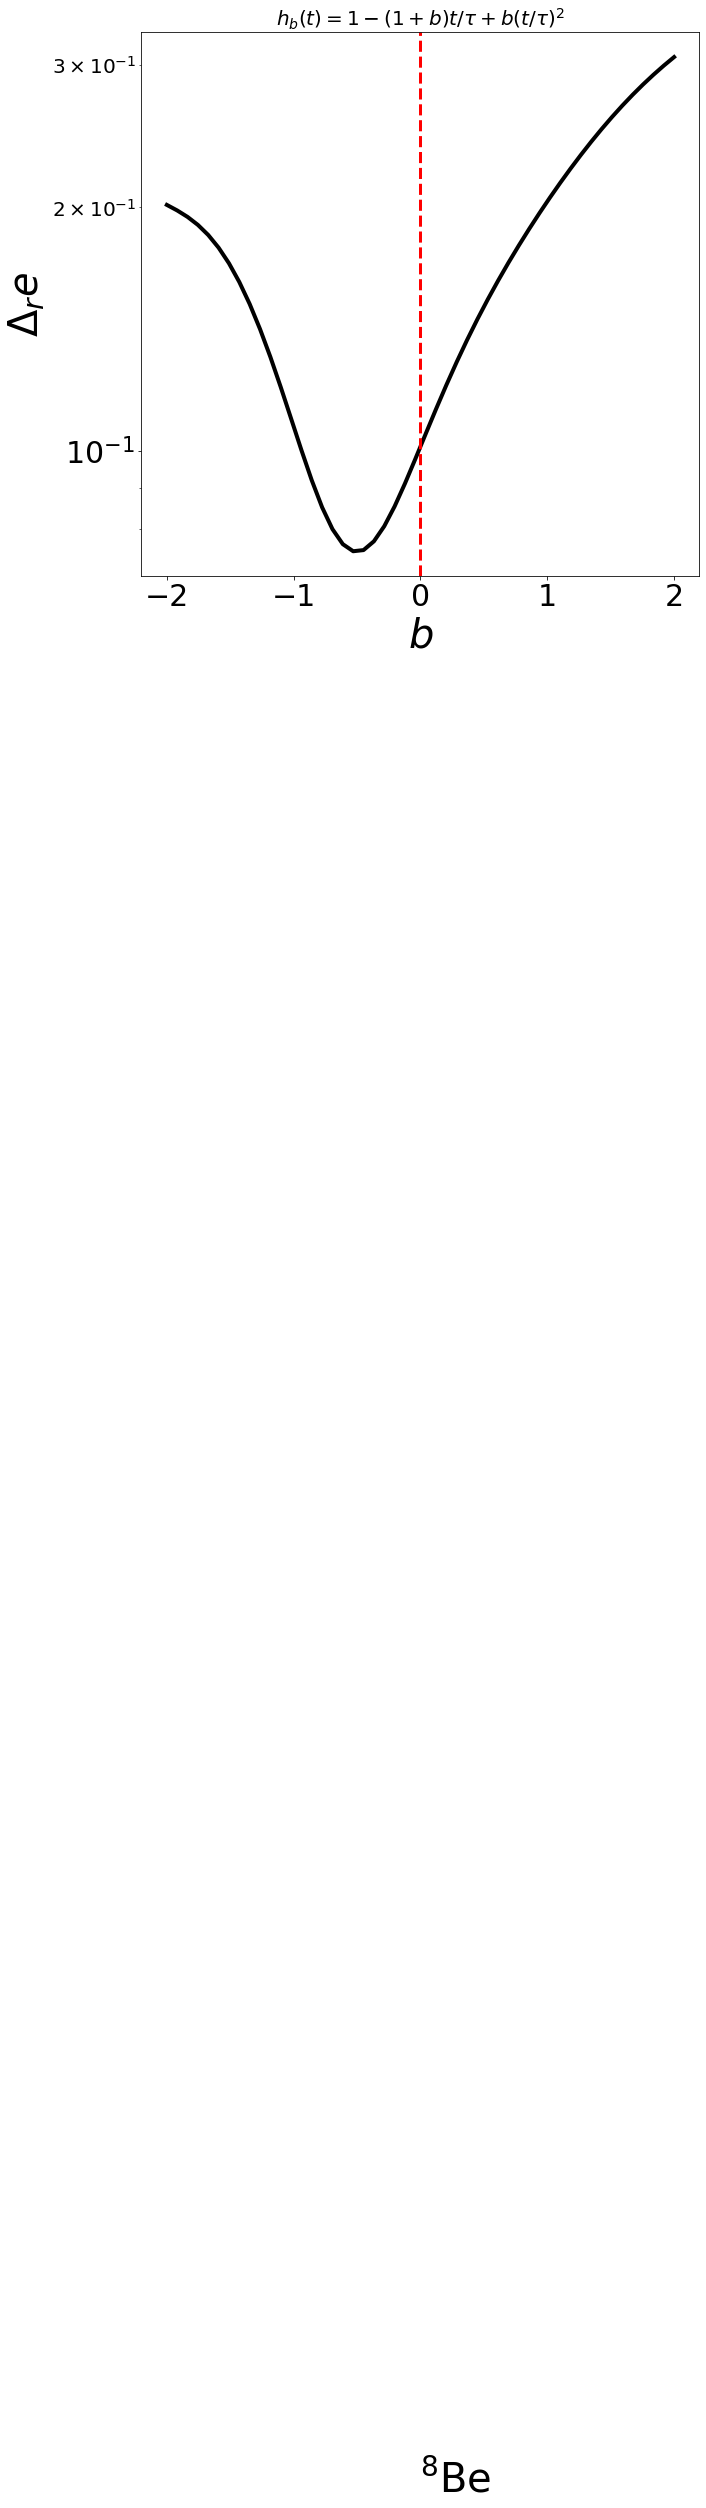

In [28]:
plt.figure(figsize=(10,10))
plt.title(r'$h_b(t)=1-(1+b)t/\tau+b(t/\tau)^2$',fontsize=20)
plt.plot(bs,energy_vs_b,linewidth=4,color='black')
plt.xlabel(r'$b$',fontsize=40)
plt.ylabel(r'$\Delta_r e$',fontsize=40)
print(0.999*np.min(energy_vs_b))
plt.text(s=title,x=0.,y=1-0.9997,fontsize=40)
plt.tick_params(labelsize=30)
plt.tick_params(labelsize=20,which='minor')
plt.axvline(x=0.,linewidth=3,color='red',linestyle='--')
plt.semilogy()
plt.show()

#### Minimum scheduler

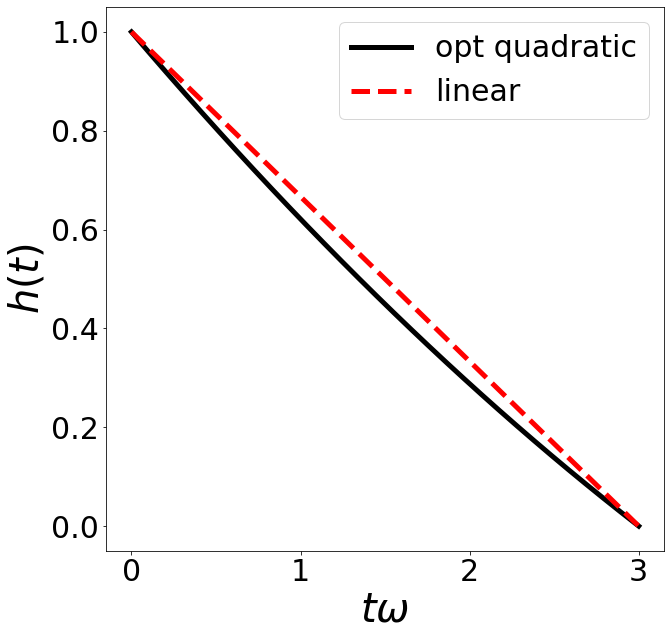

In [6]:
plt.figure(figsize=(10,10))
b_min=np.argmin(energy_vs_b)
h_quadratic=1-(1+bs[b_min])*(time/tf)+bs[b_min]*(time/tf)**2

h_driving_quadratic=h_quadratic
h_target_quadratic=1-h_quadratic

plt.xlabel(r'$t\omega$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(labelsize=30)
plt.plot(time,h_quadratic,linewidth=5,color='black',label='opt quadratic')
plt.plot(time,1-time/tf,color='red',linewidth=5,linestyle='--',label='linear')
plt.legend(fontsize=30)
plt.show()



 comments go here

### General optimal control algorithm

#### Imports

In [7]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type,Optional
from scipy.optimize import minimize
from tqdm import trange

#### Define the Class schedule with both power law expansion and F-CRAB initialization

comments go here

In [16]:
class Schedule:
    
    def __init__(self,tf:float,type:str,number_of_parameters:int,nsteps:int,seed:Optional[int]=None):
        
        self.tf=tf
        self.type=type
        self.time=np.linspace(0,self.tf,nsteps)
        self.parameters=np.zeros(2*number_of_parameters)
        if type=='F-CRAB':
            np.random.seed(seed)
            self.parameters=np.random.uniform(-1,1,size=2*number_of_parameters)
        self.number_parameters=number_of_parameters
        self.seed=seed
        
    def get_driving(self)-> np.ndarray:
        
        if self.type=='power law':
            matrix_driver=(self.parameters[:self.number_parameters,None]*(self.time[None,:]/self.tf)**np.arange(1,self.parameters.shape[0]//2+1)[:,None])
            matrix_target=(self.parameters[self.number_parameters:,None]*(self.time[None,:]/self.tf)**np.arange(1,self.parameters.shape[0]//2+1)[:,None])
            h_driver=(1-self.time/self.tf)*(1+np.sum(matrix_driver,axis=0))
            h_target=(self.time/self.tf)*(1+np.sum(matrix_target,axis=0))
        
        if self.type=='F-CRAB':
            #np.random.seed(self.seed)
            dim=self.parameters.shape[0]
            omegas=(1+np.random.uniform(-0.5,0.5,size=self.number_parameters))*np.pi*np.arange(self.number_parameters)/self.tf
            matrix_driver=(self.parameters[:dim//2,None]*np.sin(self.time[None,:]*omegas[:,None]))
            matrix_target=(self.parameters[dim//2:,None]*np.sin(self.time[None,:]*omegas[:,None]))
            
            h_driver=(1-self.time/self.tf)*(1+np.average(matrix_driver,axis=0))
            h_target=(self.time/self.tf)*(1+np.average(matrix_target,axis=0))
        return h_driver,h_target

Plot some samples of the driving

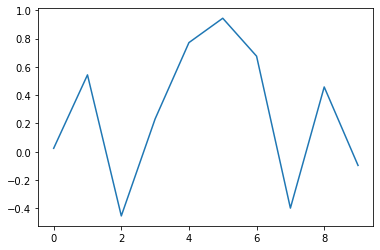

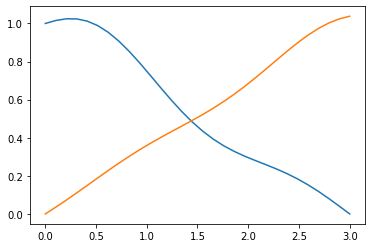

In [17]:
PowerLawScheduler=Schedule(tf=tf,type='F-CRAB',number_of_parameters=5,nsteps=nsteps)

PowerLawScheduler.parameters=np.random.uniform(-1,1,size=PowerLawScheduler.parameters.shape[0])
plt.plot(PowerLawScheduler.parameters)
plt.show()
h_driver,h_target=PowerLawScheduler.get_driving()

plt.plot(PowerLawScheduler.time,h_driver)
plt.plot(PowerLawScheduler.time,h_target)

plt.show()

#### Function to optimize (as a class)

In [18]:
class SchedulerModel(Schedule):
    
    def __init__(self,initial_state:np.ndarray,target_hamiltonian: scipy.sparse.spmatrix,initial_hamiltonian: scipy.sparse.spmatrix,tf:float,number_of_parameters:int,nsteps:int,type:str,seed:int):
        
        super().__init__(tf=tf,type=type, number_of_parameters=number_of_parameters,nsteps=nsteps,seed=seed)
        self.target_hamiltonian=target_hamiltonian
        self.initial_hamiltonian=initial_hamiltonian
        self.initial_state=initial_state
        
        
        self.energy=1000
        self.psi=None
    def forward(self,parameters):
        psi=self.initial_state
        dt=self.time[1]-self.time[0]
        self.parameters=parameters
        
        h_driver,h_target=self.get_driving()
        
        for i,t in enumerate(self.time):
            time_hamiltonian=h_driver[i]*self.initial_hamiltonian+h_target[i]*self.target_hamiltonian
            psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        self.energy=psi.conjugate().transpose().dot(self.target_hamiltonian.dot(psi))
        self.psi=psi
        return self.energy
    
    def callback(self,args):
        
        print(self.energy)
  
        
        

#### Optimization

In [29]:
model=SchedulerModel(initial_state=psi_configuration,target_hamiltonian=TargetHamiltonian.hamiltonian,initial_hamiltonian=InitialHamiltonian.hamiltonian,reference_hamiltonian=TargetHamiltonian.hamiltonian,tf=tf,nsteps=nsteps,number_of_parameters=number_of_parameters,type='fourier',seed=42,mode='annealing ansatz')
print(model.parameters.shape)

res = minimize(
                    model.forward,
                    model.parameters,
                    method='L-BFGS-B',
                    tol=10**-6,
                    callback=model.callback,
                    options=None,
                    
                )

model.parameters = res.x
energy = model.forward(model.parameters)
print(energy,egs)
print(model.parameters)


(40,)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/scipy/optimize/lbfgsb.py:351: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


(-28.686857827461942+2.220446049250313e-16j)
(-29.17795177086027+8.881784197001252e-16j)
(-29.338299474701543-1.7763568394002505e-15j)
(-29.447838571328113+0j)
(-29.572237088133157+0j)
(-29.624245600026224+0j)
(-29.687717329860128+0j)
(-29.758172041625727+3.552713678800501e-15j)
(-29.831898157175225-1.7763568394002505e-15j)
(-30.018616466619385-1.7763568394002505e-15j)
(-30.179410146069436-8.881784197001252e-16j)
(-30.266479310208098+1.7763568394002505e-15j)
(-30.27641049495994+1.7763568394002505e-15j)
(-30.280620234652723+0j)
(-30.282639558491763+0j)
(-30.284470234808925-1.7763568394002505e-15j)
(-30.28773813448492+0j)
(-30.291103753042858-1.7763568394002505e-15j)
(-30.29280108378766-1.7763568394002505e-15j)
(-30.29380461053563+0j)
(-30.29440970608413-2.220446049250313e-16j)
(-30.294669046119914+0j)
(-30.294763588085686+0j)
(-30.294912625731147+0j)
(-30.294938020178066-1.7763568394002505e-15j)
(-30.294938020177295-1.7763568394002505e-15j) -30.295394613605517
[ 0.          6.01511286  

1.5071380783957625e-05


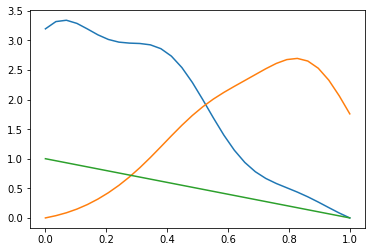

[0.9999685+0.j]


In [30]:
print(np.abs(energy-egs)/np.abs(egs))
h_driver,h_target=model.get_driving()
plt.plot(model.time,h_driver)
plt.plot(model.time,h_target)
plt.plot(model.time,1-model.time/model.tf)
plt.show()
print(model.psi.conjugate()@psi0*(psi0.conjugate().transpose() @ model.psi))

#### Check the performance with the quadratic optimization and the linear one

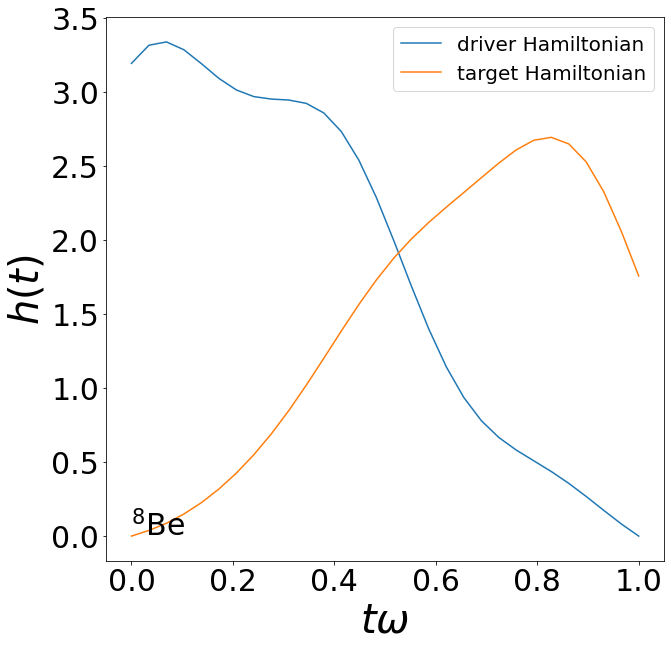

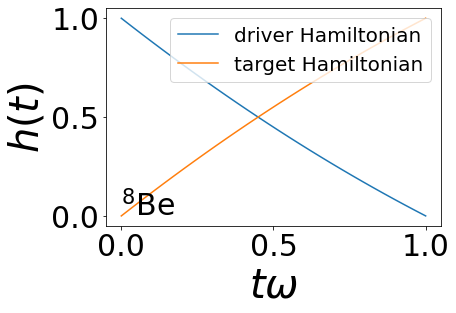

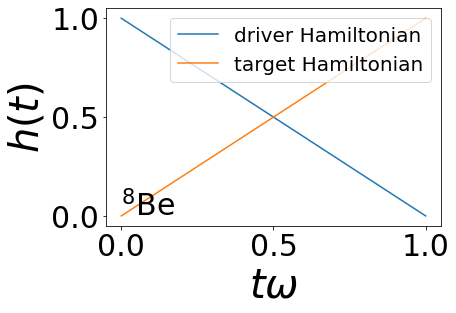

/tmp/ipykernel_748456/4221505181.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[r,j,i]=(


[3.14991085e-05+0.j]
[0.36628771+0.j]
[0.33686822+0.j]


In [31]:

nlevels=10
quantum_annealing_info=True


h_driver,h_target=model.get_driving()

drivings=[(h_driver,h_target),(h_driving_quadratic,h_target_quadratic),(1-model.time/model.tf,model.time/model.tf)]
labels=['optimal control','quadratic optimization','linear']

probabilities=np.zeros((len(drivings),nlevels,nsteps))
spectrum=np.zeros_like(probabilities)


plt.figure(figsize=(10,10))
for i,drivers in enumerate(drivings):
    h_d,h_t=drivers
    plt.plot(time,h_d,label='driver Hamiltonian')
    plt.plot(time,h_t,label='target Hamiltonian')
    plt.tick_params(labelsize=30)
    plt.xlabel(r'$t \omega$',fontsize=40)
    plt.ylabel(r'$h(t)$',fontsize=40)
    plt.legend(fontsize=20)
    plt.text(s=title,x=0.,y=0.,fontsize=30)
    plt.show()
dt=model.time[1]-model.time[0]
energy=[]
fidelity=[]

for r,drivers in enumerate(drivings):
    h_d,h_t=drivers
    psi=psi_configuration
    for i,t in enumerate(model.time):
        time_hamiltonian=h_d[i]*InitialHamiltonian.hamiltonian+h_t[i]*TargetHamiltonian.hamiltonian
        linear_time_hamiltonian=(1-time[i]/tf)*InitialHamiltonian.hamiltonian+(time[i]/tf)*TargetHamiltonian.hamiltonian        
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)
        if quantum_annealing_info==True:
            values, psis = eigsh(linear_time_hamiltonian, k=nlevels, which="SA")
            spectrum[r,:, i] = values
            for j in range(values.shape[0]):
                probabilities[r,j,i]=(
                        psis[:, j].conjugate().transpose() @ psi[:]
                    ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])


    energy.append(np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs))
    fidelity.append(1-(psi.conjugate()@psi0*(psi0.conjugate().transpose() @ psi)))
    print(fidelity[r])

### Probabilities

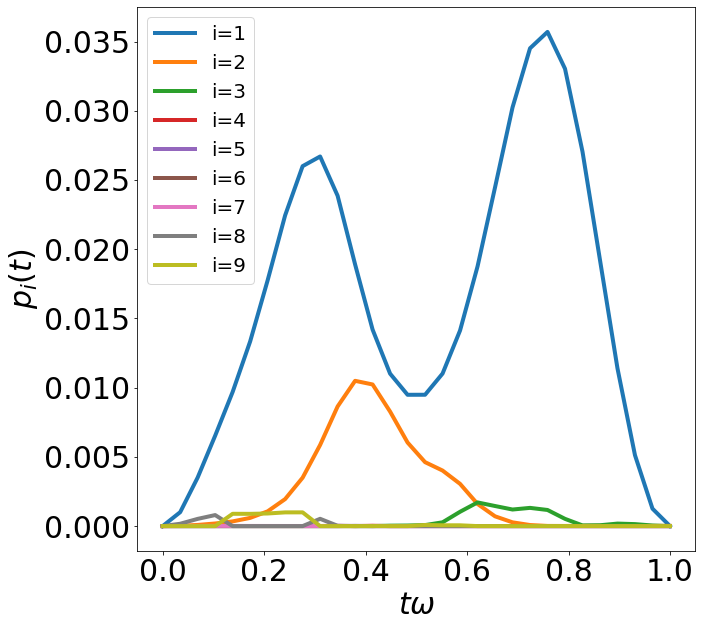

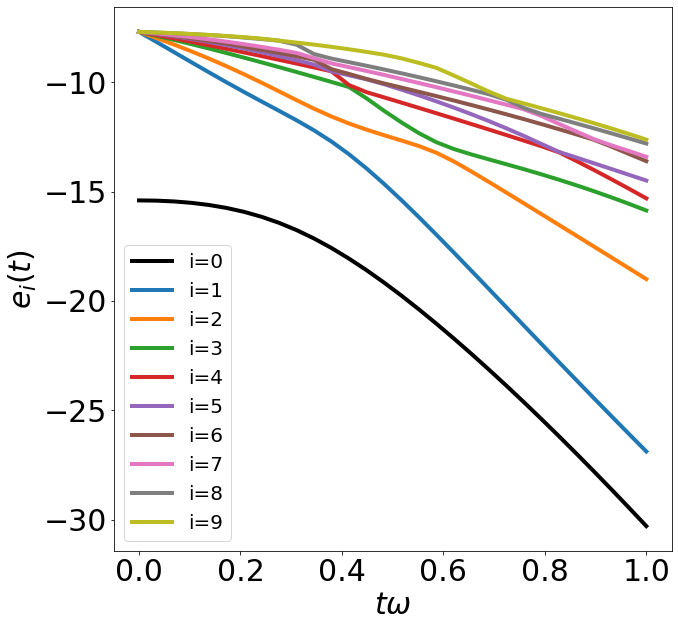

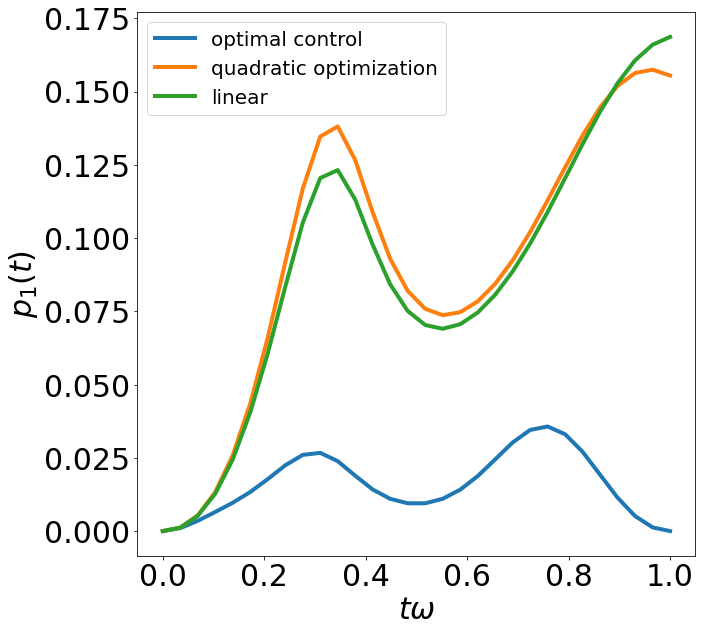

In [32]:
plt.figure(figsize=(10,10))
for i in range(1,nlevels):
    plt.plot(time,probabilities[0,i],label=f'i={i}',linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$p_i(t)$',fontsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,spectrum[0,0],label=f'i={0}',linewidth=4,color='black')
for i in range(1,nlevels):
    plt.plot(time,spectrum[0,i],label=f'i={i}',linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$e_i(t)$',fontsize=30)
plt.show()


plt.figure(figsize=(10,10))
for i in range(len(drivings)):
    plt.plot(time,probabilities[i,1],label=labels[i],linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$p_1(t)$',fontsize=30)
plt.show()

##### Get the results

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


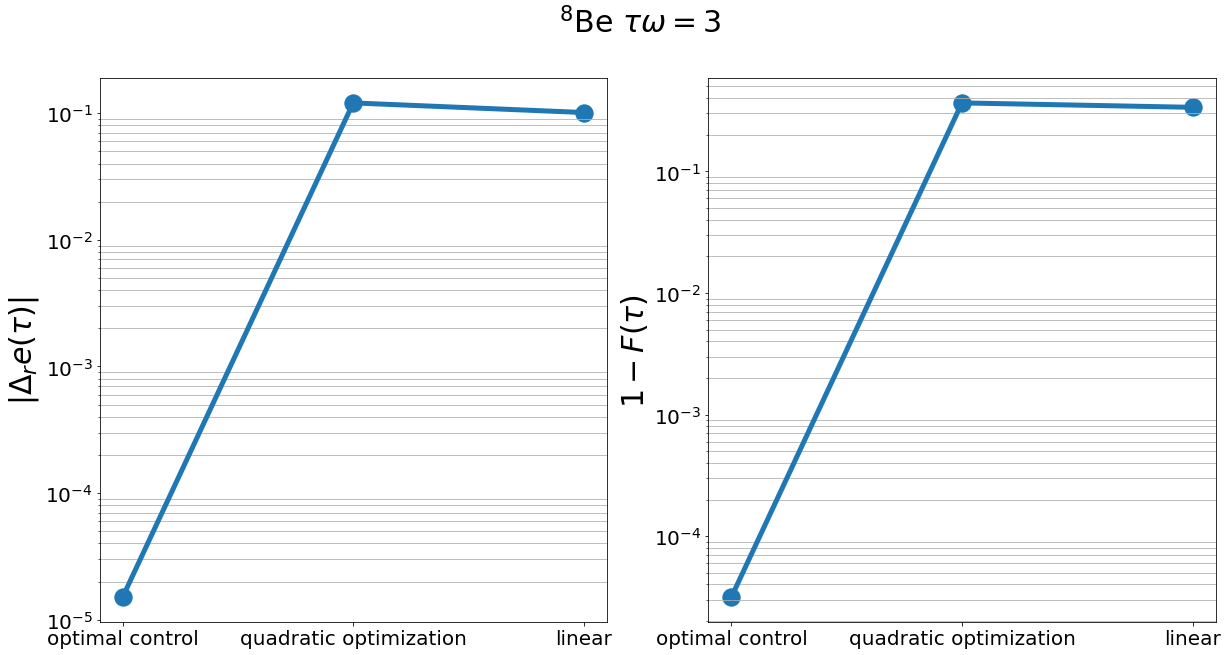

In [33]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
fig.suptitle(title+r' $\tau \omega=3$',fontsize=30)
ax[0].plot(energy,linewidth=5)
ax[0].scatter([0,1,2],energy,s=300)
ax[0].set_xticks([0,1,2],labels=labels)
ax[0].semilogy()
ax[0].set_ylabel(r'$|\Delta_r e(\tau)|$',fontsize=30)
ax[0].tick_params(labelsize=20)
ax[0].tick_params(labelsize=20,which='minor')
ax[0].grid(True,which='minor')

ax[1].plot(fidelity,linewidth=5)
ax[1].scatter([0,1,2],fidelity,s=300)
ax[1].set_xticks([0,1,2],labels=labels,fontsize=30)
ax[1].semilogy()
ax[1].set_ylabel(r'$1-F(\tau)$',fontsize=30)
ax[1].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20,which='minor')
ax[1].grid(True,which='minor')
plt.show()

### Test the transfer Learning

In [34]:
file_name:str='data/usdb.nat'
qq_filename:str='data/qq.sd'

j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{20}$Ne'


# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

# check the eigenstates
nlevels=2
egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]


# matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)
# QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
# QQoperator.get_hamiltonian()


#print('deformation=',psi0.transpose().conjugate().dot(QQoperator.hamiltonian.dot(psi0)),'\n')

min_b=np.zeros(size_a+size_b)
min_b[0]=1
#min_b[1]=1
#min_b[4]=1
min_b[5]=1

min_b[0+size_a]=1
#min_b[1+size_a]=1
#min_b[2+size_a]=1
#min_b[3+size_a]=1

#min_b[4+size_a]=1
min_b[5+size_a]=1



print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=3
nlevels=3

size= 24 12
Hamiltonian shape= (640, 640)
-41.396490072570074
initial state= [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
idx= 26
min energy= -30.21714603174604


Annealing with the transfer learning for the different drivings

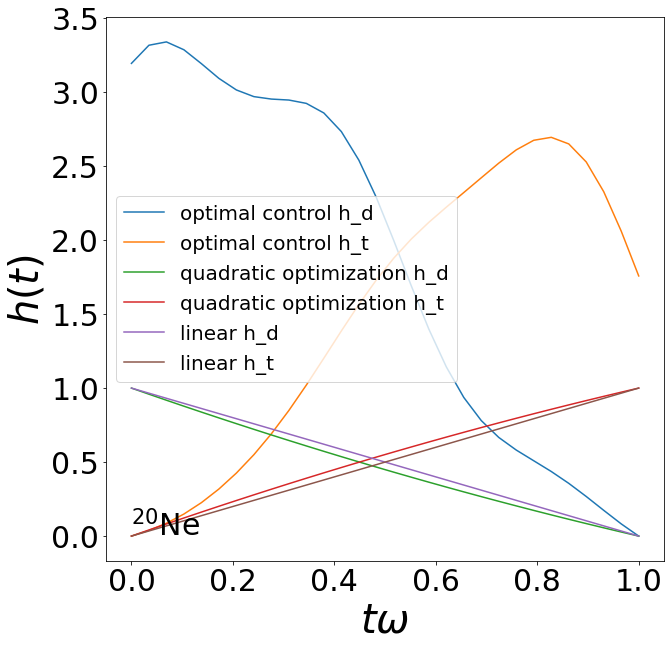

/tmp/ipykernel_748456/525027199.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[r,j,i]=(


[0.19792722+0.j]
[0.58166079+0.j]
[0.62219599+0.j]


In [35]:
nlevels=3
quantum_annealing_info=True


h_driver,h_target=model.get_driving()

drivings=[(h_driver,h_target),(h_driving_quadratic,h_target_quadratic),(1-model.time/model.tf,model.time/model.tf)]
labels=['optimal control','quadratic optimization','linear']

probabilities=np.zeros((len(drivings),nlevels,nsteps))
spectrum=np.zeros_like(probabilities)


plt.figure(figsize=(10,10))
for i,drivers in enumerate(drivings):
    h_d,h_t=drivers
    plt.plot(time,h_d,label=labels[i]+' h_d')
    plt.plot(time,h_t,label=labels[i]+' h_t')
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.legend(fontsize=20)
plt.text(s=title,x=0.,y=0.,fontsize=30)
plt.show()
dt=model.time[1]-model.time[0]
energy=[]
fidelity=[]

for r,drivers in enumerate(drivings):
    h_d,h_t=drivers
    psi=psi_configuration
    for i,t in enumerate(model.time):
        time_hamiltonian=h_d[i]*InitialHamiltonian.hamiltonian+h_t[i]*TargetHamiltonian.hamiltonian
        linear_time_hamiltonian=(1-time[i]/tf)*InitialHamiltonian.hamiltonian+(time[i]/tf)*TargetHamiltonian.hamiltonian        
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)
        if quantum_annealing_info==True:
            values, psis = eigsh(linear_time_hamiltonian, k=nlevels, which="SA")
            spectrum[r,:, i] = values
            for j in range(values.shape[0]):
                probabilities[r,j,i]=(
                        psis[:, j].conjugate().transpose() @ psi[:]
                    ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])


    energy.append(np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs))
    fidelity.append(1-(psi.conjugate()@psi0*(psi0.conjugate().transpose() @ psi)))
    print(fidelity[r])

#### Results

Probabilities

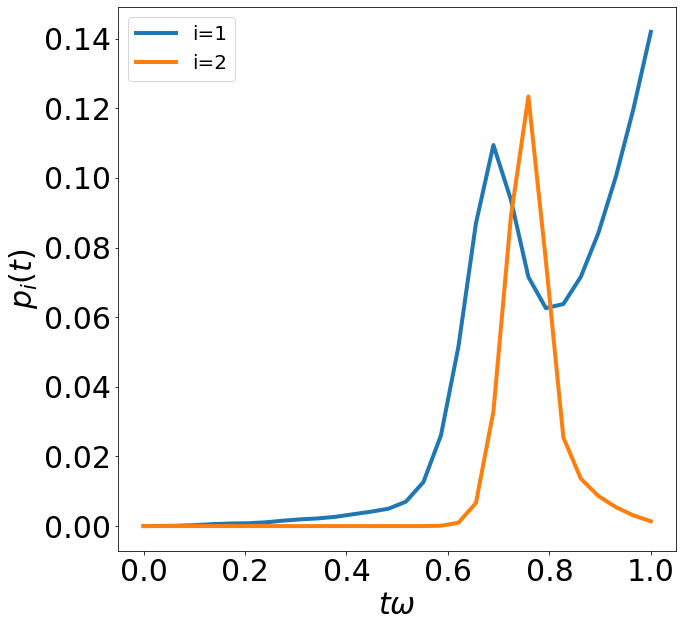

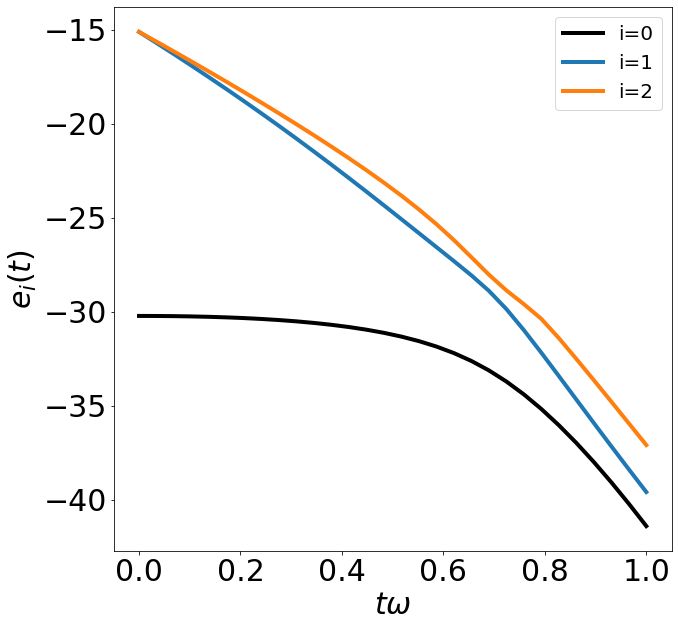

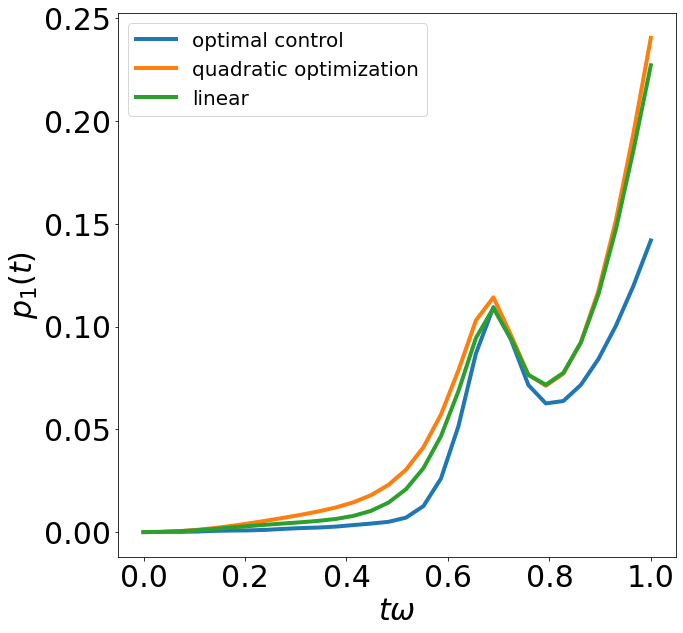

In [36]:
plt.figure(figsize=(10,10))
for i in range(1,nlevels):
    plt.plot(time,probabilities[0,i],label=f'i={i}',linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$p_i(t)$',fontsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,spectrum[0,0],label=f'i={0}',linewidth=4,color='black')
for i in range(1,nlevels):
    plt.plot(time,spectrum[0,i],label=f'i={i}',linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$e_i(t)$',fontsize=30)
plt.show()


plt.figure(figsize=(10,10))
for i in range(len(drivings)):
    plt.plot(time,probabilities[i,1],label=labels[i],linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$p_1(t)$',fontsize=30)
plt.show()

Accuracy

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


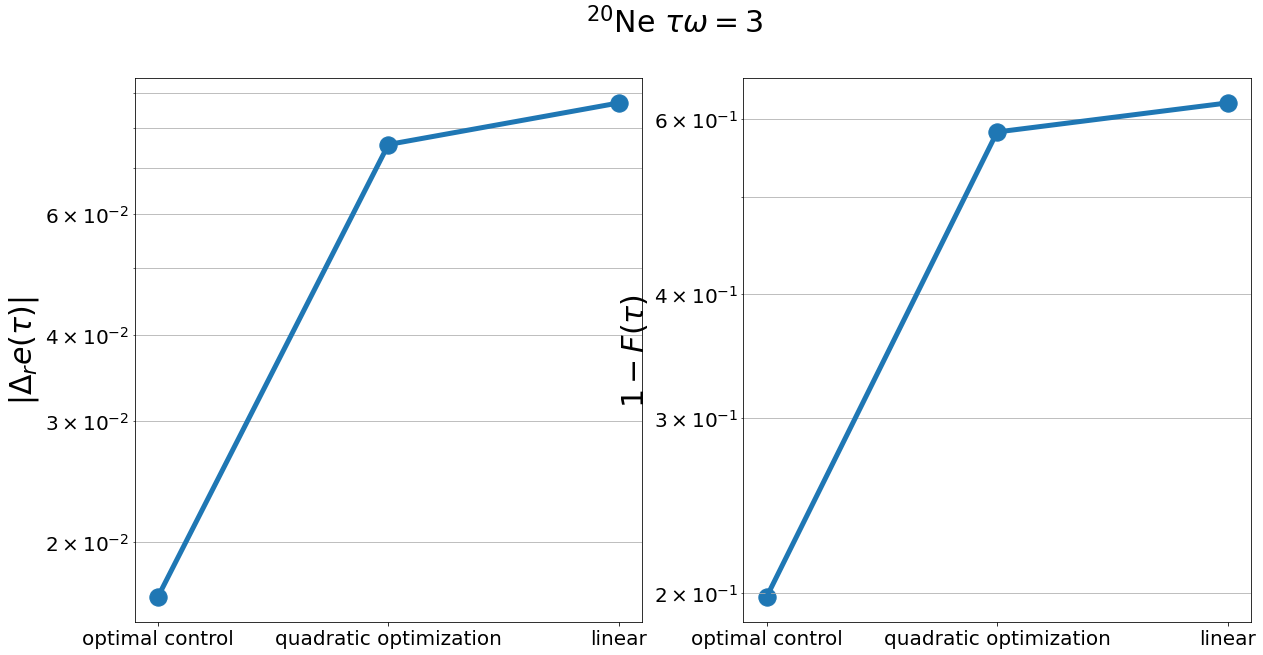

In [37]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
fig.suptitle(title+r' $\tau \omega=3$',fontsize=30)
ax[0].plot(energy,linewidth=5)
ax[0].scatter([0,1,2],energy,s=300)
ax[0].set_xticks([0,1,2],labels=labels)
ax[0].semilogy()
ax[0].set_ylabel(r'$|\Delta_r e(\tau)|$',fontsize=30)
ax[0].tick_params(labelsize=20)
ax[0].tick_params(labelsize=20,which='minor')
ax[0].grid(True,which='minor')

ax[1].plot(fidelity,linewidth=5)
ax[1].scatter([0,1,2],fidelity,s=300)
ax[1].set_xticks([0,1,2],labels=labels,fontsize=30)
ax[1].semilogy()
ax[1].set_ylabel(r'$1-F(\tau)$',fontsize=30)
ax[1].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20,which='minor')
ax[1].grid(True,which='minor')
plt.show()